In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from libpysal.weights import Queen, Rook, KNN
from libpysal.weights import lag_spatial
from esda.moran import Moran
from spreg import ML_Lag, ML_Error

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.stats import shapiro


In [ ]:

gdf = gpd.read_file("/content/covid19_eng.gpkg")

print(gdf.shape)
print(gdf.columns)


(149, 508)
Index(['objectid', 'ctyua19cd', 'ctyua19nm', 'Region', 'bng_n', 'long', 'lat',
       'st_areasha', 'X2020.01.31', 'X2020.02.01',
       ...
       'Information_and_communication', 'Financial_and_insurance',
       'Real_estate', 'Scientific_and_technical', 'Administrative_and_support',
       'Public_administration_and_defence', 'Education',
       'Human_health_and_social_work', 'Other_industry', 'geometry'],
      dtype='object', length=508)


In [ ]:
y_var = "Human_health_and_social_work"

x_vars = [
    "Education",
    "Financial_and_insurance",
    "Information_and_communication",
    "Real_estate"
]

gdf = gdf[[y_var] + x_vars + ["geometry"]].dropna()


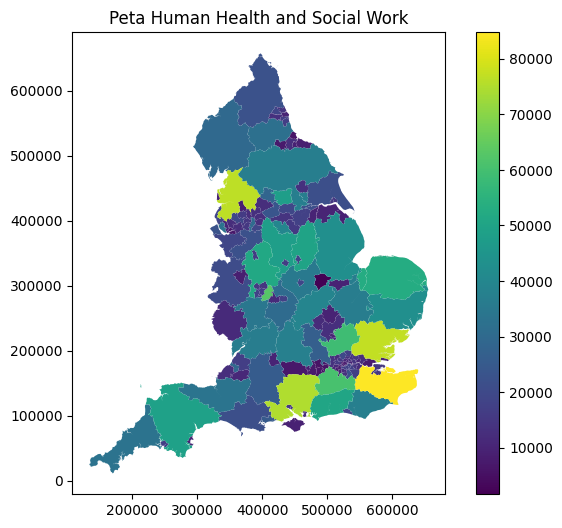

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
gdf.plot(column=y_var, cmap='viridis', legend=True, ax=ax)
plt.title("Peta Human Health and Social Work")
plt.show()


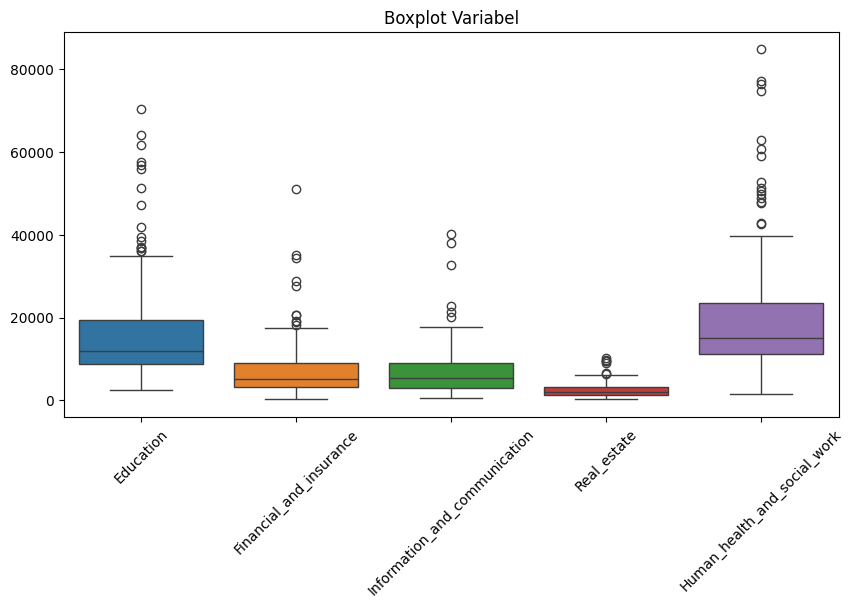

In [ ]:
plt.figure(figsize=(10,5))
sns.boxplot(data=gdf[x_vars + [y_var]])
plt.xticks(rotation=45)
plt.title("Boxplot Variabel")
plt.show()


In [ ]:
desc_stats = gdf[x_vars + [y_var]].describe().T
desc_stats["variance"] = gdf[x_vars + [y_var]].var()
desc_stats["range"] = desc_stats["max"] - desc_stats["min"]
desc_stats["cv_%"] = (desc_stats["std"] / desc_stats["mean"]) * 100

print(desc_stats.round(3))


                               count       mean        std     min      25%  \
Education                      149.0  16712.745  13157.946  2386.0   8827.0   
Financial_and_insurance        149.0   7408.443   7010.503   387.0   3196.0   
Information_and_communication  149.0   6874.846   6152.111   518.0   3018.0   
Real_estate                    149.0   2466.168   1842.945   216.0   1286.0   
Human_health_and_social_work   149.0  20947.906  15772.200  1585.0  11219.0   

                                   50%      75%      max      variance  \
Education                      11951.0  19418.0  70363.0  1.731315e+08   
Financial_and_insurance         5190.0   9028.0  51117.0  4.914716e+07   
Information_and_communication   5315.0   8995.0  40213.0  3.784847e+07   
Real_estate                     1906.0   3191.0  10188.0  3.396445e+06   
Human_health_and_social_work   15118.0  23558.0  84796.0  2.487623e+08   

                                 range    cv_%  
Education                      

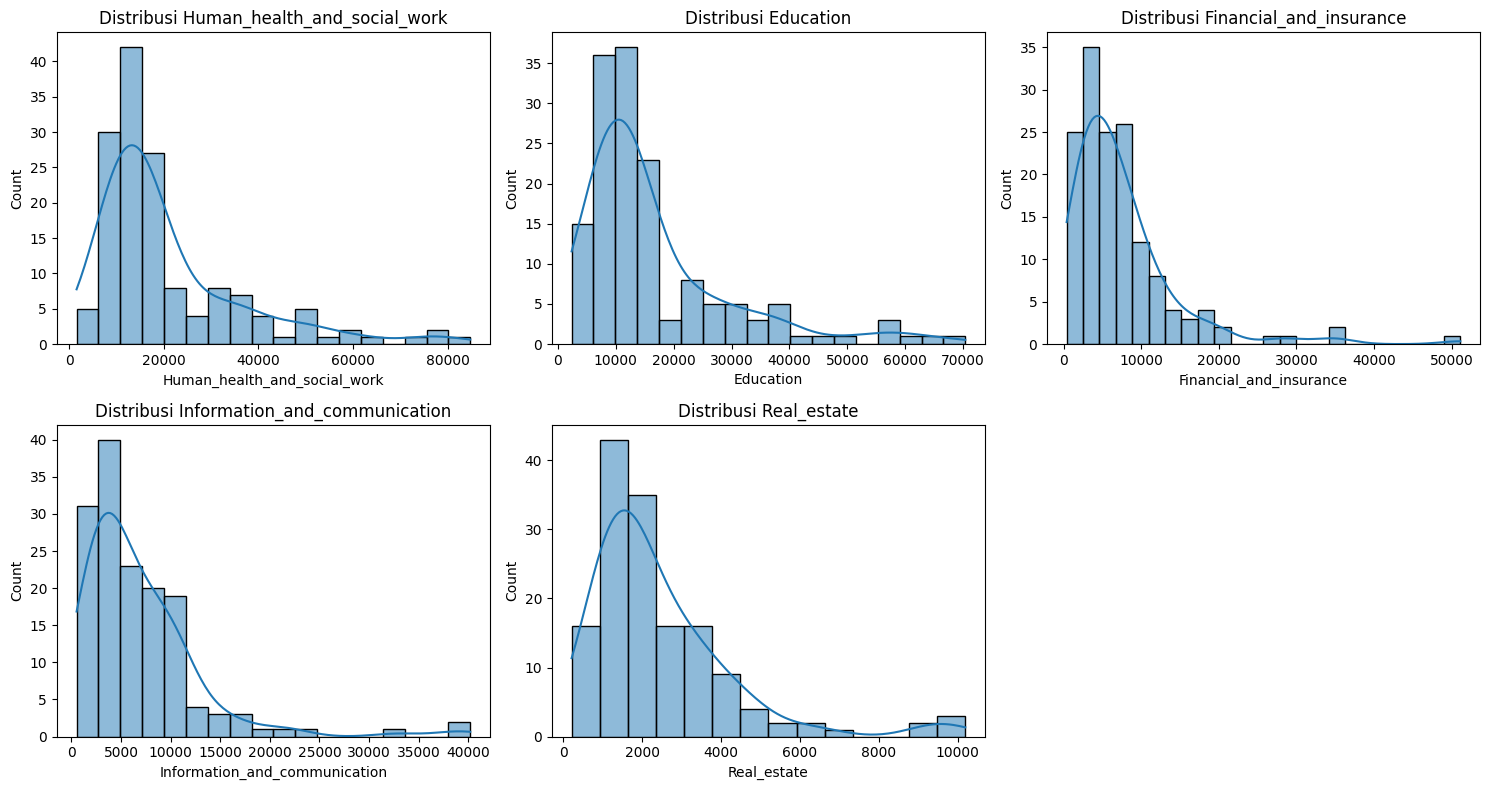

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Gabungkan semua variabel
all_vars = [y_var] + x_vars
n = len(all_vars)

# Tentukan jumlah kolom (misal 3)
cols = 3
rows = math.ceil(n / cols)

plt.figure(figsize=(cols*5, rows*4))

for i, var in enumerate(all_vars):
    plt.subplot(rows, cols, i+1)
    sns.histplot(gdf[var], kde=True)
    plt.title(f"Distribusi {var}")
    plt.tight_layout()

plt.show()


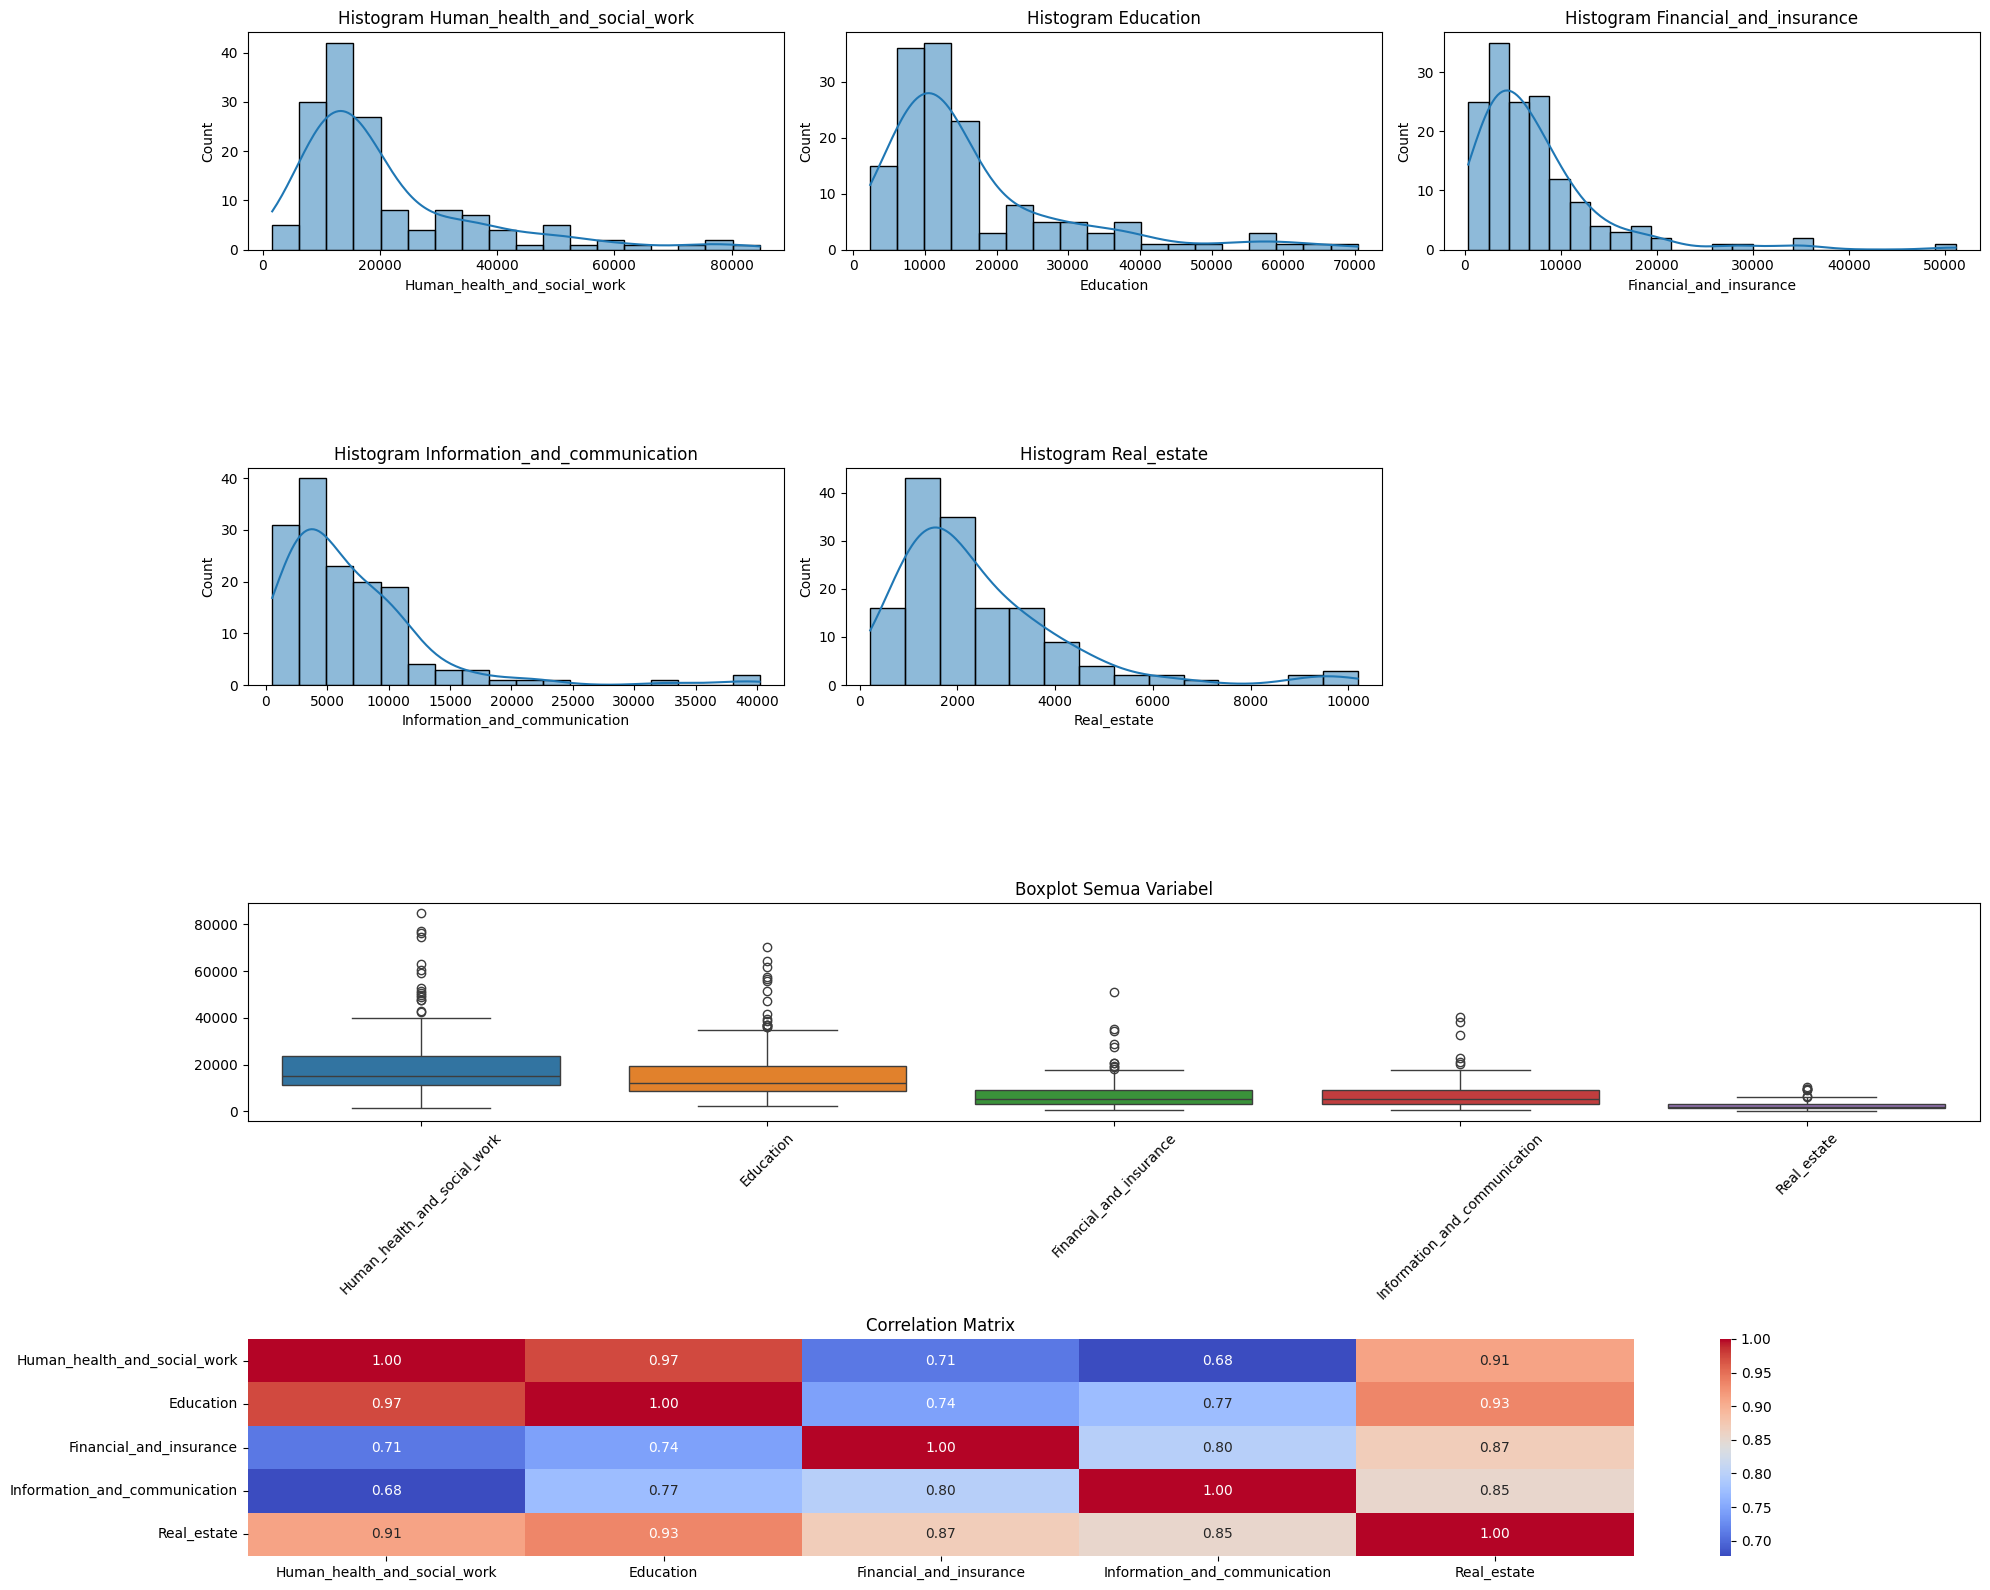

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

all_vars = [y_var] + x_vars
n = len(all_vars)

# Ukuran figure besar
fig = plt.figure(figsize=(20, 16))

# =========================================
# 1️⃣ HISTOGRAM (baris 1-2)
# =========================================
cols = 3
rows_hist = math.ceil(n / cols)

for i, var in enumerate(all_vars):
    ax = plt.subplot(4, cols, i+1)
    sns.histplot(gdf[var], kde=True, ax=ax)
    ax.set_title(f"Histogram {var}")

# =========================================
# 2️⃣ BOXPLOT (baris berikutnya)
# =========================================
ax_box = plt.subplot(4, 1, 3)
sns.boxplot(data=gdf[all_vars], ax=ax_box)
ax_box.set_title("Boxplot Semua Variabel")
ax_box.tick_params(axis='x', rotation=45)

# =========================================
# 3️⃣ CORRELATION HEATMAP
# =========================================
ax_corr = plt.subplot(4, 1, 4)
corr = gdf[all_vars].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", ax=ax_corr)
ax_corr.set_title("Correlation Matrix")

plt.tight_layout()
plt.show()


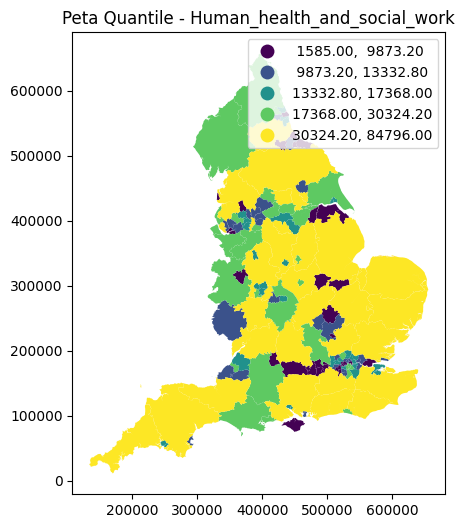

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
gdf.plot(column=y_var,
         scheme='quantiles',
         k=5,
         cmap='viridis',
         legend=True,
         ax=ax)
plt.title("Peta Quantile - " + y_var)
plt.show()


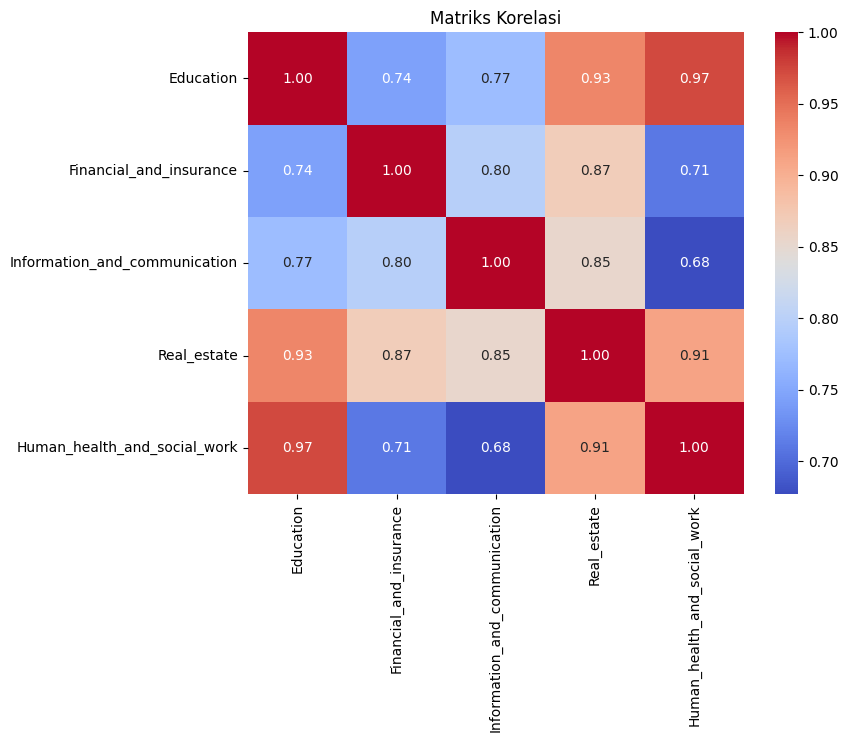

In [ ]:
corr_matrix = gdf[x_vars + [y_var]].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix,
            annot=True,
            cmap='coolwarm',
            fmt=".2f")
plt.title("Matriks Korelasi")
plt.show()


In [ ]:
X = gdf[x_vars]
X = sm.add_constant(X)
y = gdf[y_var]

ols_model = sm.OLS(y, X).fit()
print(ols_model.summary())


                                 OLS Regression Results                                 
Dep. Variable:     Human_health_and_social_work   R-squared:                       0.968
Model:                                      OLS   Adj. R-squared:                  0.967
Method:                           Least Squares   F-statistic:                     1102.
Date:                          Sun, 15 Feb 2026   Prob (F-statistic):          7.30e-107
Time:                                  16:36:40   Log-Likelihood:                -1393.9
No. Observations:                           149   AIC:                             2798.
Df Residuals:                               144   BIC:                             2813.
Df Model:                                     4                                         
Covariance Type:                      nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
------------

In [ ]:
ols_model.llf

np.float64(-1393.8741987833596)

In [ ]:
stat, p = shapiro(ols_model.resid)
print("Shapiro p-value:", p)


Shapiro p-value: 1.2581935326148474e-05


In [ ]:
stat

np.float64(0.9445218374029202)

In [ ]:
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                   for i in range(X.shape[1])]
print(vif_data)


                        Variable        VIF
0                          const   2.849183
1                      Education   9.076119
2        Financial_and_insurance   4.898781
3  Information_and_communication   3.867866
4                    Real_estate  18.584896


In [ ]:
bp_test = het_breuschpagan(ols_model.resid, X)
print("Breusch-Pagan p-value:", bp_test[1])


Breusch-Pagan p-value: 1.37174473305092e-10


In [ ]:
bp_test

(np.float64(52.01163973188351),
 np.float64(1.37174473305092e-10),
 np.float64(19.305605591966447),
 np.float64(9.80827685176847e-13))

In [ ]:
w_queen = Queen.from_dataframe(gdf)
w_rook = Rook.from_dataframe(gdf)
w_knn = KNN.from_dataframe(gdf, k=5)

w_queen.transform = 'r'
w_rook.transform = 'r'
w_knn.transform = 'r'


/tmp/ipython-input-1601756193.py:1: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w_queen = Queen.from_dataframe(gdf)
/usr/local/lib/python3.12/dist-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 43.
  W.__init__(self, neighbors, ids=ids, **kw)
/tmp/ipython-input-1601756193.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w_rook = Rook.from_dataframe(gdf)


('WARNING: ', 43, ' is an island (no neighbors)')
('WARNING: ', 43, ' is an island (no neighbors)')


/usr/local/lib/python3.12/dist-packages/libpysal/weights/contiguity.py:61: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 43.
  W.__init__(self, neighbors, ids=ids, **kw)


In [ ]:
for var in [y_var] + x_vars:
    mi = Moran(gdf[var], w_queen)
    print(f"{var}")
    print("Moran I:", round(mi.I,4))
    print("p-value:", round(mi.p_sim,4))
    print("----------------------")


Human_health_and_social_work
Moran I: 0.0058
p-value: 0.411
----------------------
Education
Moran I: -0.0113
p-value: 0.483
----------------------
Financial_and_insurance
Moran I: 0.1607
p-value: 0.007
----------------------
Information_and_communication
Moran I: 0.1632
p-value: 0.007
----------------------
Real_estate
Moran I: 0.0022
p-value: 0.427
----------------------


In [ ]:
from esda.moran import Moran

residual = ols_model.resid
mi_resid = Moran(residual, w_queen)

print("Moran I residual:", mi_resid.I)
print("p-value:", mi_resid.p_sim)


Moran I residual: 0.21926973966282481
p-value: 0.001


In [ ]:
y_sp = gdf[y_var].values.reshape(-1,1)
X_sp = gdf[x_vars].values

sar_model = ML_Lag(y_sp, X_sp, w=w_queen,
                   name_y=y_var, name_x=x_vars)

print(sar_model.summary)


REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :Human_health_and_social_work                Number of Observations:         149
Mean dependent var  :  20947.9060                Number of Variables   :           6
S.D. dependent var  :  15772.2003                Degrees of Freedom    :         143
Pseudo R-squared    :      0.9684
Spatial Pseudo R-squared:  0.9683
Log likelihood      :  -1393.7915
Sigma-square ML     :7808503.0500                Akaike info criterion :    2799.583
S.E of regression   :   2794.3699                Schwarz criterion     :    2817.607

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------------------------

In [ ]:
sem_model = ML_Error(y_sp, X_sp, w=w_queen,
                     name_y=y_var, name_x=x_vars)

print(sem_model.summary)


REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ML SPATIAL ERROR (METHOD = full)
---------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :Human_health_and_social_work                Number of Observations:         149
Mean dependent var  :  20947.9060                Number of Variables   :           5
S.D. dependent var  :  15772.2003                Degrees of Freedom    :         144
Pseudo R-squared    :      0.9680
Log likelihood      :  -1389.1500
Sigma-square ML     :7212718.3175                Akaike info criterion :    2788.300
S.E of regression   :   2685.6504                Schwarz criterion     :    2803.320

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT    

/usr/local/lib/python3.12/dist-packages/spreg/ml_error.py:184: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  res = minimize_scalar(


In [ ]:
weights_dict = {
    "Queen": w_queen,
    "Rook": w_rook,
    "KNN": w_knn
}

for name, w in weights_dict.items():
    model = ML_Error(y_sp, X_sp, w=w)
    print(name, "AIC:", model.aic)


/usr/local/lib/python3.12/dist-packages/spreg/ml_error.py:184: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  res = minimize_scalar(
/usr/local/lib/python3.12/dist-packages/spreg/ml_error.py:184: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  res = minimize_scalar(
/usr/local/lib/python3.12/dist-packages/spreg/ml_error.py:184: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  res = minimize_scalar(


Queen AIC: 2788.300049694544
Rook AIC: 2788.300049694544
KNN AIC: 2779.707753789259


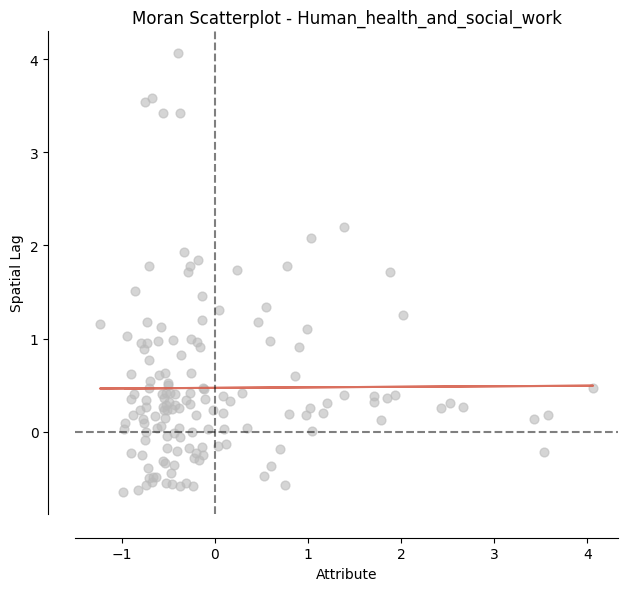

In [ ]:
from splot.esda import moran_scatterplot
from esda.moran import Moran

mi = Moran(gdf[y_var], w_queen)

fig, ax = moran_scatterplot(mi)
plt.title("Moran Scatterplot - " + y_var)
plt.show()


In [ ]:
best_model = ML_Error(y_sp, X_sp, w=w_queen)

gdf["residual"] = best_model.u


/usr/local/lib/python3.12/dist-packages/spreg/ml_error.py:184: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  res = minimize_scalar(


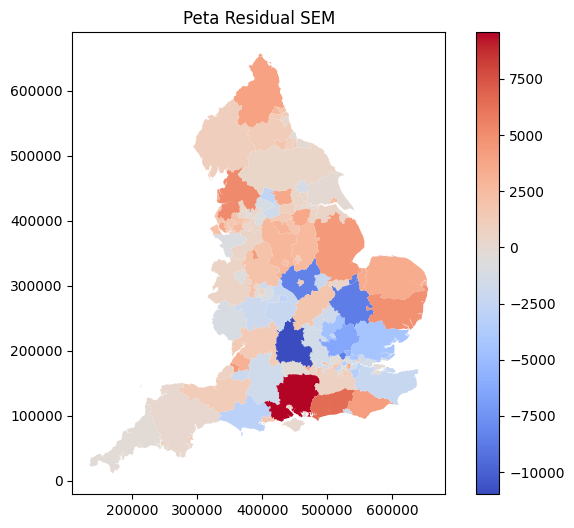

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
gdf.plot(column="residual", cmap='coolwarm', legend=True, ax=ax)
plt.title("Peta Residual SEM")
plt.show()


In [ ]:
print("OLS R2:", round(ols_model.rsquared,4))
print("SAR AIC:", round(sar_model.aic,4))
print("SEM AIC:", round(sem_model.aic,4))


OLS R2: 0.9684
SAR AIC: 2799.583
SEM AIC: 2788.3


In [ ]:
from libpysal.weights import Queen

w_queen = Queen.from_dataframe(gdf)
w_queen.transform = 'r'


/tmp/ipython-input-66895802.py:3: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w_queen = Queen.from_dataframe(gdf)


('WARNING: ', 43, ' is an island (no neighbors)')


/usr/local/lib/python3.12/dist-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 43.
  W.__init__(self, neighbors, ids=ids, **kw)


In [ ]:
from esda.moran import Moran_Local

lisa = Moran_Local(gdf[y_var], w_queen)

# Tambahkan ke dataframe
gdf["local_I"] = lisa.Is
gdf["p_sim"] = lisa.p_sim
gdf["quadrant"] = lisa.q


/usr/local/lib/python3.12/dist-packages/esda/moran.py:1354: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim


In [ ]:
print(gdf.columns)


Index(['Human_health_and_social_work', 'Education', 'Financial_and_insurance',
       'Information_and_communication', 'Real_estate', 'geometry', 'residual',
       'local_I', 'p_sim', 'quadrant'],
      dtype='object')


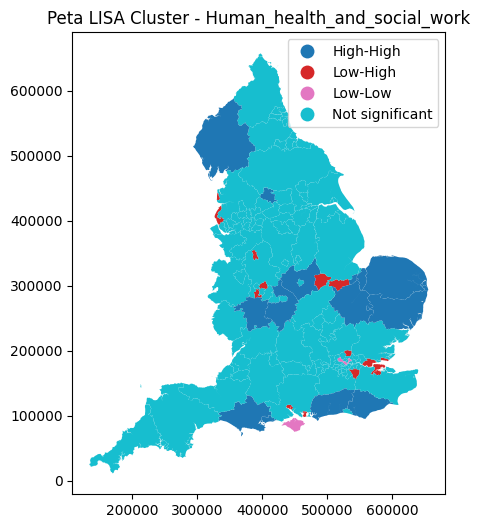

In [ ]:
gdf["cluster"] = "Not significant"

gdf.loc[(gdf["quadrant"]==1) & (gdf["p_sim"]<0.05), "cluster"] = "High-High"
gdf.loc[(gdf["quadrant"]==2) & (gdf["p_sim"]<0.05), "cluster"] = "Low-High"
gdf.loc[(gdf["quadrant"]==3) & (gdf["p_sim"]<0.05), "cluster"] = "Low-Low"
gdf.loc[(gdf["quadrant"]==4) & (gdf["p_sim"]<0.05), "cluster"] = "High-Low"

fig, ax = plt.subplots(1,1, figsize=(8,6))
gdf.plot(column="cluster",
         categorical=True,
         legend=True,
         ax=ax)
plt.title("Peta LISA Cluster - " + y_var)
plt.show()


In [ ]:
gdf[gdf['cluster'] != 'Not significant']

,Human_health_and_social_work,Education,Financial_and_insurance,Information_and_communication,Real_estate,geometry,residual,local_I,p_sim,quadrant,cluster
8,9171.0,4089.0,1706.0,1266.0,634.0,"MULTIPOLYGON (((333020.1 438557.204, 333033.49...",2830.284485,-2.631084,0.012,2,Low-High
16,1585.0,2386.0,387.0,518.0,216.0,"MULTIPOLYGON (((493992.196 318917.1, 494224.59...",-2263.892502,-1.411296,0.046,2,Low-High
20,15734.0,8300.0,2890.0,2238.0,1087.0,"MULTIPOLYGON (((387441.7 354808.097, 387445.40...",4366.341106,-0.637272,0.045,2,Low-High
28,9551.0,7056.0,4432.0,3227.0,1086.0,"MULTIPOLYGON (((531399.296 310254.5, 532299.59...",192.305354,-0.850931,0.045,2,Low-High
30,10391.0,8157.0,9046.0,2590.0,1321.0,"MULTIPOLYGON (((583492.903 189477.102, 583823....",-1155.518367,-2.387381,0.007,2,Low-High
31,7516.0,6122.0,4873.0,2189.0,999.0,"MULTIPOLYGON (((565866.298 188081.102, 565905....",-1324.076644,-1.279361,0.048,2,Low-High
32,14754.0,11215.0,6336.0,3398.0,1591.0,"MULTIPOLYGON (((577398.02 179312.3, 577407.41 ...",-278.447292,-1.589747,0.001,2,Low-High
41,12147.0,9763.0,2614.0,3541.0,1145.0,"MULTIPOLYGON (((466843.564 104122.414, 467094....",-5.072989,-1.904231,0.019,2,Low-High
42,15091.0,11639.0,4702.0,3370.0,1303.0,"MULTIPOLYGON (((442148.101 116944.304, 442233....",453.661637,-1.267245,0.019,2,Low-High
43,9277.0,5831.0,888.0,1090.0,927.0,"MULTIPOLYGON (((450238.1 96097.4, 450286.85 96...",95.108868,-0.000000,0.001,3,Low-Low


In [ ]:
# OLS
if hasattr(ols_model, "u"):
    gdf["residual_ols"] = ols_model.u.flatten()
else:
    gdf["residual_ols"] = ols_model.resid

# SAR
if hasattr(sar_model, "u"):
    gdf["residual_sar"] = sar_model.u.flatten()
else:
    gdf["residual_sar"] = sar_model.resid


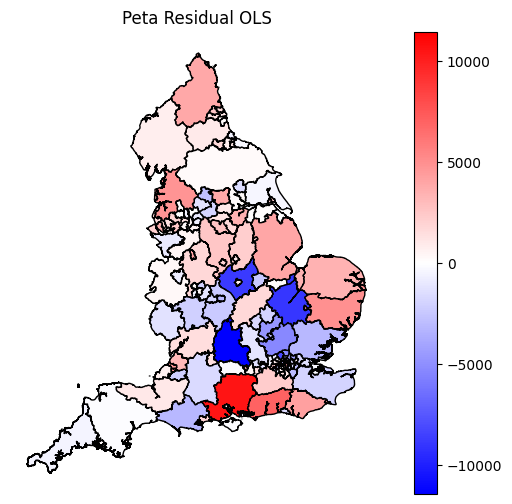

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Skala simetris
vmax_ols = np.abs(gdf["residual_ols"]).max()
vmin_ols = -vmax_ols

fig, ax = plt.subplots(1, 1, figsize=(8,6))

gdf.plot(
    column="residual_ols",
    cmap="bwr",
    vmin=vmin_ols,
    vmax=vmax_ols,
    legend=True,
    edgecolor="black",
    ax=ax
)

ax.set_title("Peta Residual OLS")
ax.axis("off")

plt.show()


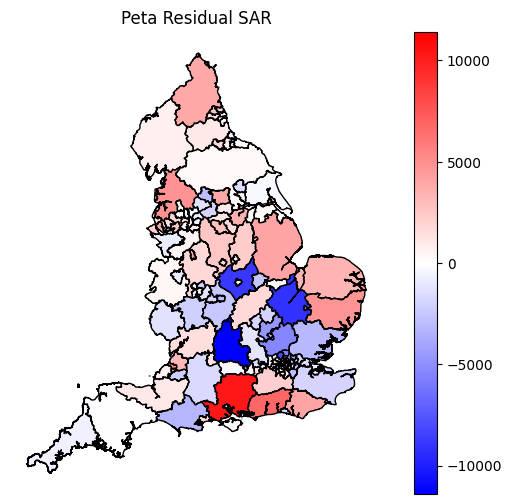

In [ ]:
vmax_sar = np.abs(gdf["residual_sar"]).max()
vmin_sar = -vmax_sar

fig, ax = plt.subplots(1, 1, figsize=(8,6))

gdf.plot(
    column="residual_sar",
    cmap="bwr",
    vmin=vmin_sar,
    vmax=vmax_sar,
    legend=True,
    edgecolor="black",
    ax=ax
)

ax.set_title("Peta Residual SAR")
ax.axis("off")

plt.show()


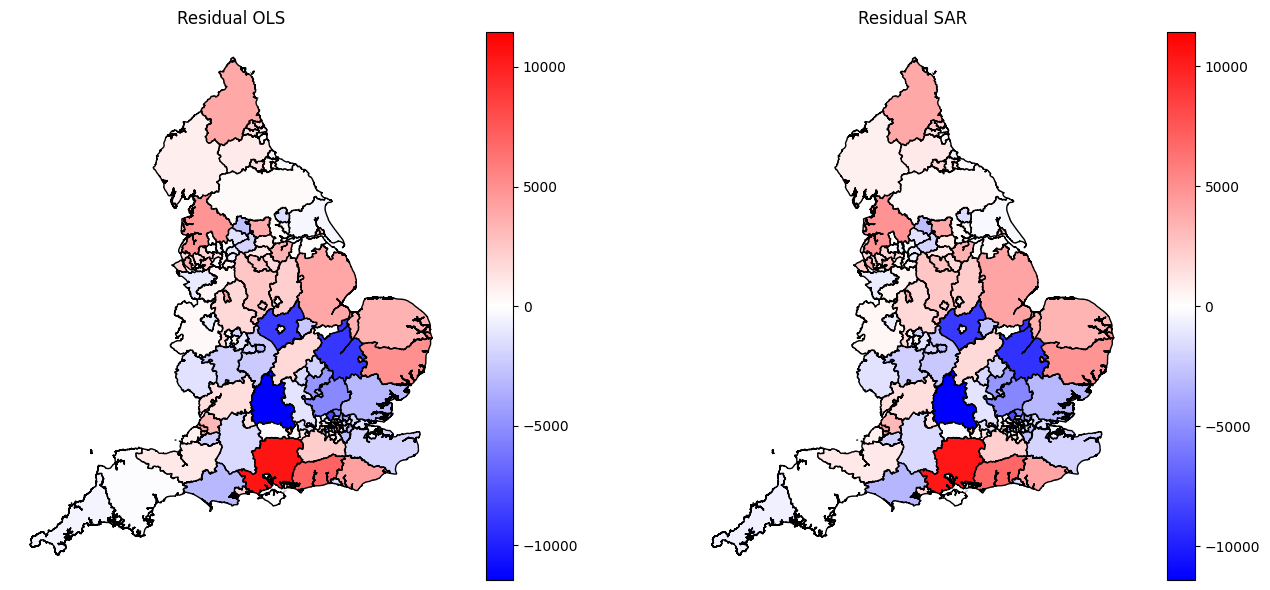

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14,6))

# OLS
gdf.plot(
    column="residual_ols",
    cmap="bwr",
    vmin=vmin_ols,
    vmax=vmax_ols,
    legend=True,
    edgecolor="black",
    ax=axes[0]
)
axes[0].set_title("Residual OLS")
axes[0].axis("off")

# SAR
gdf.plot(
    column="residual_sar",
    cmap="bwr",
    vmin=vmin_sar,
    vmax=vmax_sar,
    legend=True,
    edgecolor="black",
    ax=axes[1]
)
axes[1].set_title("Residual SAR")
axes[1].axis("off")

plt.tight_layout()
plt.show()


In [38]:
gdf.to_csv('dataset.csv')